## Synchronous Requests vs Asynchronous Requests to Task API
This notebook demonstrates the performance impact when processing requests to an API synchronously vs asynchronously

In [7]:
import requests
import asyncio
import aiohttp
import os
from dotenv import load_dotenv
from typing import Optional, Dict, Any
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
# Load environment variables from .env file
load_dotenv()

BASE_URL = os.getenv("BASE_URL")

In [3]:
async def fetch(session: aiohttp.ClientSession, url: str) -> Dict[str, Any]:
    async with session.get(url) as response:
        return await response.json()

async def get_tasks_async() -> Dict[str, Any]:
    connector = aiohttp.TCPConnector(limit=60)
    async with aiohttp.ClientSession() as session:
        url = f"{BASE_URL}/tasks"
        return await fetch(session, url)
    
async def gather_with_concurrency(n, *coros):
    semaphore = asyncio.Semaphore(n)

    async def sem_coro(coro):
        async with semaphore:
            return await coro
    return await asyncio.gather(*(sem_coro(c) for c in coros))

def get_tasks_sync() -> Dict[str, Any]:
    url = f"{BASE_URL}/tasks"
    res =  requests.get(url)
    return res.json()

In [17]:
num_repeat = [1, 10, 100, 1000]
trials = []
for rpt in num_repeat:
    #synchronous
    sync_start_time = time.time()
    for i in range(rpt):
        get_tasks_sync()
    sync_end_time = time.time()
    sync_elapsed = sync_end_time - sync_start_time
    #asynchronous
    async_start_time = time.time()
    tasks = []
    for i in range(rpt):
        tasks.append(get_tasks_async())
    ##limit to max 100 requests at a time
    await gather_with_concurrency(100, *tasks)
    async_end_time = time.time()
    async_elapsed = async_end_time - async_start_time
    trials += [
        {
            "requests": str(rpt),
            "request_type": "synchronous",
            "time_elapsed": sync_elapsed
        },
        {
            "requests": str(rpt),
            "request_type": "asynchronous",
            "time_elapsed": async_elapsed
        },
    ]

In [18]:
df = pd.DataFrame(trials)
df.head(20)

,requests,request_type,time_elapsed
0,1,synchronous,0.018835
1,1,asynchronous,0.027317
2,10,synchronous,0.235459
3,10,asynchronous,0.051353
4,100,synchronous,2.596421
5,100,asynchronous,0.342199
6,1000,synchronous,23.378763
7,1000,asynchronous,3.485429


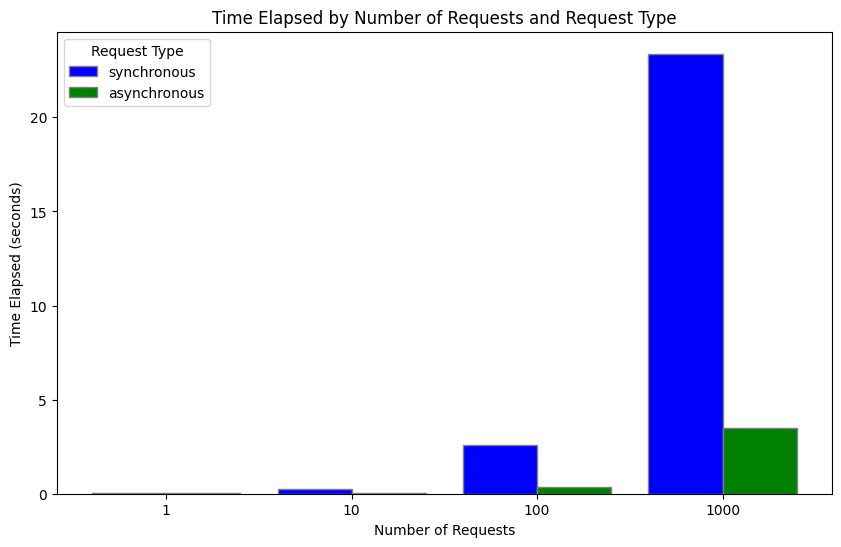

In [22]:
import numpy as np

colors = {'synchronous': 'blue', 'asynchronous': 'green'}
plt.figure(figsize=(10, 6))
bar_width = 0.4
request_types = df['request_type'].unique()
unique_requests = df['requests'].unique()

r1 = np.arange(len(unique_requests))
r2 = [x + bar_width for x in r1]

for i, request_type in enumerate(request_types):
    subset = df[df['request_type'] == request_type]
    # Adjust the position of the bars for each request type
    if request_type == 'synchronous':
        plt.bar(r1, subset['time_elapsed'], color=colors[request_type], width=bar_width, edgecolor='grey', label=request_type)
    else:
        plt.bar(r2, subset['time_elapsed'], color=colors[request_type], width=bar_width, edgecolor='grey', label=request_type)

plt.xlabel('Number of Requests')
plt.ylabel('Time Elapsed (seconds)')
plt.title('Time Elapsed by Number of Requests and Request Type')
plt.xticks([r + bar_width / 2 for r in range(len(unique_requests))], unique_requests)
plt.legend(title='Request Type')
plt.show()